In [60]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, accuracy_score
import time
import datetime
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA

In [61]:
# Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Reading and analysing the data

#### Olist Customers Dataset

In [62]:
print ('---- Customers Dataset ----')
customers=pd.read_csv('/content/drive/MyDrive/AI-ML Team Assignments/Problem1/Olist/olist_customers_dataset.csv')
display(customers)

---- Customers Dataset ----


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


In [63]:
# Overview of data
for col in customers.columns.values:
  list_val=pd.unique(customers[col])
  print("--> "+col+" is of type "+str(customers[col].dtypes)+", has "+str(len(list_val))+" unique values and "+str(customers[col].isna().sum())+" null entries")
  if len(list_val)<10:
    print('    These are: ',end="")
    for n in range(len(list_val)-1):
      print(list_val[n],end=", ")
    print(list_val[-1])
    print(customers[col].value_counts())

--> customer_id is of type object, has 99441 unique values and 0 null entries
--> customer_unique_id is of type object, has 96096 unique values and 0 null entries
--> customer_zip_code_prefix is of type int64, has 14994 unique values and 0 null entries
--> customer_city is of type object, has 4119 unique values and 0 null entries
--> customer_state is of type object, has 27 unique values and 0 null entries


#### Olist Orders Dataset

In [64]:
print ('---- Orders Dataset ----')
orders=pd.read_csv('/content/drive/MyDrive/AI-ML Team Assignments/Problem1/Olist/olist_orders_dataset.csv')
display(orders)

---- Orders Dataset ----


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [65]:
# Overview of data
for col in orders.columns.values:
  list_val=pd.unique(orders[col])
  print("--> "+col+" is of type "+str(orders[col].dtypes)+", has "+str(len(list_val))+" unique values and "+str(orders[col].isna().sum())+" null entries")
  if len(list_val)<10:
    print('    These are: ',end="")
    for n in range(len(list_val)-1):
      print(list_val[n],end=", ")
    print(list_val[-1])
    print(orders[col].value_counts())

--> order_id is of type object, has 99441 unique values and 0 null entries
--> customer_id is of type object, has 99441 unique values and 0 null entries
--> order_status is of type object, has 8 unique values and 0 null entries
    These are: delivered, invoiced, shipped, processing, unavailable, canceled, created, approved
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64
--> order_purchase_timestamp is of type object, has 98875 unique values and 0 null entries
--> order_approved_at is of type object, has 90734 unique values and 160 null entries
--> order_delivered_carrier_date is of type object, has 81019 unique values and 1783 null entries
--> order_delivered_customer_date is of type object, has 95665 unique values and 2965 null entries
--> order_estimated_delivery_date is of type object, has 459 unique values and 0 null entries


In [66]:
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at']).dt.date
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp']).dt.date
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date']).dt.date
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date']).dt.date
orders['delivery_time'] = (orders['order_delivered_customer_date'] - orders['order_approved_at']).dt.days
orders['approval_time'] = (orders['order_approved_at'] - orders['order_purchase_timestamp']).dt.days
orders['early_delivery_from_estimate'] = (orders['order_estimated_delivery_date'] - orders['order_delivered_customer_date']).dt.days
orders = orders.drop(['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date'],axis=1)
display(orders)

,order_id,customer_id,order_status,delivery_time,approval_time,early_delivery_from_estimate
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,8.0,0.0,8.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,12.0,2.0,6.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,9.0,0.0,18.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,14.0,0.0,13.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,3.0,0.0,10.0
...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,8.0,0.0,11.0
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,22.0,0.0,2.0
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,25.0,0.0,6.0
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,17.0,0.0,21.0


#### Olist Geolocation Dataset

In [67]:
print ('---- Geolocation Dataset ----')
geolocation=pd.read_csv('/content/drive/MyDrive/AI-ML Team Assignments/Problem1/Olist/olist_geolocation_dataset.csv')
display(geolocation)

---- Geolocation Dataset ----


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000158,99950,-28.068639,-52.010705,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS
1000161,99980,-28.388932,-51.846871,david canabarro,RS


In [68]:
# Overview of data
for col in geolocation.columns.values:
  list_val=pd.unique(geolocation[col])
  print("--> "+col+" is of type "+str(geolocation[col].dtypes)+", has "+str(len(list_val))+" unique values and "+str(geolocation[col].isna().sum())+" null entries")
  if len(list_val)<10:
    print('    These are: ',end="")
    for n in range(len(list_val)-1):
      print(list_val[n],end=", ")
    print(list_val[-1])
    print(geolocation[col].value_counts())

--> geolocation_zip_code_prefix is of type int64, has 19015 unique values and 0 null entries
--> geolocation_lat is of type float64, has 717358 unique values and 0 null entries
--> geolocation_lng is of type float64, has 717613 unique values and 0 null entries
--> geolocation_city is of type object, has 8011 unique values and 0 null entries
--> geolocation_state is of type object, has 27 unique values and 0 null entries


#### Olist Order Items Dataset

In [69]:
print ('---- Order Items Dataset ----')
order_items=pd.read_csv('/content/drive/MyDrive/AI-ML Team Assignments/Problem1/Olist/olist_order_items_dataset.csv')
display(order_items)

---- Order Items Dataset ----


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [70]:
# Overview of data
for col in order_items.columns.values:
  list_val=pd.unique(order_items[col])
  print("--> "+col+" is of type "+str(order_items[col].dtypes)+", has "+str(len(list_val))+" unique values and "+str(order_items[col].isna().sum())+" null entries")
  if len(list_val)<10:
    print('    These are: ',end="")
    for n in range(len(list_val)-1):
      print(list_val[n],end=", ")
    print(list_val[-1])
    print(order_items[col].value_counts())

--> order_id is of type object, has 98666 unique values and 0 null entries
--> order_item_id is of type int64, has 21 unique values and 0 null entries
--> product_id is of type object, has 32951 unique values and 0 null entries
--> seller_id is of type object, has 3095 unique values and 0 null entries
--> shipping_limit_date is of type object, has 93318 unique values and 0 null entries
--> price is of type float64, has 5968 unique values and 0 null entries
--> freight_value is of type float64, has 6999 unique values and 0 null entries


#### Olist Order Payments Dataset

In [71]:
print ('---- Order Payments Dataset ----')
order_payments=pd.read_csv('/content/drive/MyDrive/AI-ML Team Assignments/Problem1/Olist/olist_order_payments_dataset.csv')
display(order_payments)

---- Order Payments Dataset ----


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54


In [72]:
# Overview of data
for col in order_payments.columns.values:
  list_val=pd.unique(order_payments[col])
  print("--> "+col+" is of type "+str(order_payments[col].dtypes)+", has "+str(len(list_val))+" unique values and "+str(order_payments[col].isna().sum())+" null entries")
  if len(list_val)<10:
    print('    These are: ',end="")
    for n in range(len(list_val)-1):
      print(list_val[n],end=", ")
    print(list_val[-1])
    print(order_payments[col].value_counts())

--> order_id is of type object, has 99440 unique values and 0 null entries
--> payment_sequential is of type int64, has 29 unique values and 0 null entries
--> payment_type is of type object, has 5 unique values and 0 null entries
    These are: credit_card, boleto, voucher, debit_card, not_defined
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64
--> payment_installments is of type int64, has 24 unique values and 0 null entries
--> payment_value is of type float64, has 29077 unique values and 0 null entries


#### Olist Products Dataset

In [73]:
print ('---- Order products Dataset ----')
products=pd.read_csv('/content/drive/MyDrive/AI-ML Team Assignments/Problem1/Olist/olist_products_dataset.csv')
display(products)

---- Order products Dataset ----


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


In [74]:
# Overview of data
for col in products.columns.values:
  list_val=pd.unique(products[col])
  print("--> "+col+" is of type "+str(products[col].dtypes)+", has "+str(len(list_val))+" unique values and "+str(products[col].isna().sum())+" null entries")
  if len(list_val)<10:
    print('    These are: ',end="")
    for n in range(len(list_val)-1):
      print(list_val[n],end=", ")
    print(list_val[-1])
    print(products[col].value_counts())

--> product_id is of type object, has 32951 unique values and 0 null entries
--> product_category_name is of type object, has 74 unique values and 610 null entries
--> product_name_lenght is of type float64, has 67 unique values and 610 null entries
--> product_description_lenght is of type float64, has 2961 unique values and 610 null entries
--> product_photos_qty is of type float64, has 20 unique values and 610 null entries
--> product_weight_g is of type float64, has 2205 unique values and 2 null entries
--> product_length_cm is of type float64, has 100 unique values and 2 null entries
--> product_height_cm is of type float64, has 103 unique values and 2 null entries
--> product_width_cm is of type float64, has 96 unique values and 2 null entries


#### Olist Sellers Dataset

In [75]:
print ('---- Order sellers Dataset ----')
sellers=pd.read_csv('/content/drive/MyDrive/AI-ML Team Assignments/Problem1/Olist/olist_sellers_dataset.csv')
display(sellers)

---- Order sellers Dataset ----


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS


In [76]:
# Overview of data
for col in sellers.columns.values:
  list_val=pd.unique(sellers[col])
  print("--> "+col+" is of type "+str(sellers[col].dtypes)+", has "+str(len(list_val))+" unique values and "+str(sellers[col].isna().sum())+" null entries")
  if len(list_val)<10:
    print('    These are: ',end="")
    for n in range(len(list_val)-1):
      print(list_val[n],end=", ")
    print(list_val[-1])
    print(sellers[col].value_counts())

--> seller_id is of type object, has 3095 unique values and 0 null entries
--> seller_zip_code_prefix is of type int64, has 2246 unique values and 0 null entries
--> seller_city is of type object, has 611 unique values and 0 null entries
--> seller_state is of type object, has 23 unique values and 0 null entries


#### Olist Product Category Name Translation

In [77]:
print ('---- Product Category Name Translation Dataset ----')
product_category_name_translation=pd.read_csv('/content/drive/MyDrive/AI-ML Team Assignments/Problem1/Olist/product_category_name_translation.csv')
display(product_category_name_translation)

---- Product Category Name Translation Dataset ----


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
...,...,...
66,flores,flowers
67,artes_e_artesanato,arts_and_craftmanship
68,fraldas_higiene,diapers_and_hygiene
69,fashion_roupa_infanto_juvenil,fashion_childrens_clothes


In [78]:
# Overview of data
for col in product_category_name_translation.columns.values:
  list_val=pd.unique(product_category_name_translation[col])
  print("--> "+col+" is of type "+str(product_category_name_translation[col].dtypes)+", has "+str(len(list_val))+" unique values and "+str(product_category_name_translation[col].isna().sum())+" null entries")
  if len(list_val)<10:
    print('    These are: ',end="")
    for n in range(len(list_val)-1):
      print(list_val[n],end=", ")
    print(list_val[-1])
    print(product_category_name_translation[col].value_counts())

--> product_category_name is of type object, has 71 unique values and 0 null entries
--> product_category_name_english is of type object, has 71 unique values and 0 null entries


#### Olist Order Reviews Dataset

In [79]:
print ('---- Order Reviews Dataset ----')
order_reviews=pd.read_csv('/content/drive/MyDrive/AI-ML Team Assignments/Problem1/Olist/olist_order_reviews_dataset.csv')
display(order_reviews)

---- Order Reviews Dataset ----


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99995,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99996,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99997,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13
99998,be360f18f5df1e0541061c87021e6d93,f8bd3f2000c28c5342fedeb5e50f2e75,1,NaN,Solicitei a compra de uma capa de retrovisor c...,2017-12-15 00:00:00,2017-12-16 01:29:43


In [80]:
# Overview of data
for col in order_reviews.columns.values:
  list_val=pd.unique(order_reviews[col])
  print("--> "+col+" is of type "+str(order_reviews[col].dtypes)+", has "+str(len(list_val))+" unique values and "+str(order_reviews[col].isna().sum())+" null entries")
  if len(list_val)<10:
    print('    These are: ',end="")
    for n in range(len(list_val)-1):
      print(list_val[n],end=", ")
    print(list_val[-1])
    print(order_reviews[col].value_counts())

--> review_id is of type object, has 99173 unique values and 0 null entries
--> order_id is of type object, has 99441 unique values and 0 null entries
--> review_score is of type int64, has 5 unique values and 0 null entries
    These are: 4, 5, 1, 3, 2
5    57420
4    19200
1    11858
3     8287
2     3235
Name: review_score, dtype: int64
--> review_comment_title is of type object, has 4601 unique values and 88285 null entries
--> review_comment_message is of type object, has 36922 unique values and 58247 null entries
--> review_creation_date is of type object, has 637 unique values and 0 null entries
--> review_answer_timestamp is of type object, has 99010 unique values and 0 null entries


In [81]:
order_reviews = order_reviews.drop(['review_id', 'review_comment_title', 'review_creation_date', 'review_answer_timestamp'], axis=1)
#order_reviews = order_reviews.dropna(axis=0, subset=['review_comment_message'])
display(order_reviews)

,order_id,review_score,review_comment_message
0,73fc7af87114b39712e6da79b0a377eb,4,NaN
1,a548910a1c6147796b98fdf73dbeba33,5,NaN
2,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN
3,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...
...,...,...,...
99995,22ec9f0669f784db00fa86d035cf8602,5,NaN
99996,55d4004744368f5571d1f590031933e4,5,"Excelente mochila, entrega super rápida. Super..."
99997,7725825d039fc1f0ceb7635e3f7d9206,4,NaN
99998,f8bd3f2000c28c5342fedeb5e50f2e75,1,Solicitei a compra de uma capa de retrovisor c...


#### Creating a merged dataset

In [82]:
data = pd.merge(order_reviews, orders, on='order_id', how='left')
display(data)

,order_id,review_score,review_comment_message,customer_id,order_status,delivery_time,approval_time,early_delivery_from_estimate
0,73fc7af87114b39712e6da79b0a377eb,4,NaN,41dcb106f807e993532d446263290104,delivered,6.0,0.0,16.0
1,a548910a1c6147796b98fdf73dbeba33,5,NaN,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,9.0,0.0,5.0
2,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,e226dfed6544df5b7b87a48208690feb,delivered,13.0,0.0,21.0
3,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,11.0,0.0,20.0
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,5986b333ca0d44534a156a52a8e33a83,delivered,18.0,0.0,9.0
...,...,...,...,...,...,...,...,...
99995,22ec9f0669f784db00fa86d035cf8602,5,NaN,d0d7086dea6fcf42b9b690b9f3745c58,delivered,5.0,0.0,12.0
99996,55d4004744368f5571d1f590031933e4,5,"Excelente mochila, entrega super rápida. Super...",fcc7b1caafe3b77fd587bab964c4d1fb,delivered,3.0,0.0,16.0
99997,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,3aa00401736823c73e9fe8683328fa6b,delivered,8.0,0.0,16.0
99998,f8bd3f2000c28c5342fedeb5e50f2e75,1,Solicitei a compra de uma capa de retrovisor c...,8df587ce8a11ee97b3de9ef3405245c2,delivered,2.0,2.0,15.0


In [83]:
# Overview of data
for col in data.columns.values:
  list_val=pd.unique(data[col])
  print("--> "+col+" is of type "+str(data[col].dtypes)+", has "+str(len(list_val))+" unique values and "+str(data[col].isna().sum())+" null entries")
  if len(list_val)<10:
    print('    These are: ',end="")
    for n in range(len(list_val)-1):
      print(list_val[n],end=", ")
    print(list_val[-1])
    print(data[col].value_counts())

--> order_id is of type object, has 99441 unique values and 0 null entries
--> review_score is of type int64, has 5 unique values and 0 null entries
    These are: 4, 5, 1, 3, 2
5    57420
4    19200
1    11858
3     8287
2     3235
Name: review_score, dtype: int64
--> review_comment_message is of type object, has 36922 unique values and 58247 null entries
--> customer_id is of type object, has 99441 unique values and 0 null entries
--> order_status is of type object, has 8 unique values and 0 null entries
    These are: delivered, canceled, shipped, processing, unavailable, invoiced, created, approved
delivered      97015
shipped         1118
canceled         629
unavailable      611
invoiced         318
processing       302
created            5
approved           2
Name: order_status, dtype: int64
--> delivery_time is of type float64, has 148 unique values and 3001 null entries
--> approval_time is of type float64, has 24 unique values and 161 null entries
--> early_delivery_from_est

In [84]:
data['delivery_time'] = data['delivery_time'].fillna(0.0)
data['early_delivery_from_estimate'] = data['early_delivery_from_estimate'].fillna(0.0)
display(data)

,order_id,review_score,review_comment_message,customer_id,order_status,delivery_time,approval_time,early_delivery_from_estimate
0,73fc7af87114b39712e6da79b0a377eb,4,NaN,41dcb106f807e993532d446263290104,delivered,6.0,0.0,16.0
1,a548910a1c6147796b98fdf73dbeba33,5,NaN,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,9.0,0.0,5.0
2,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,e226dfed6544df5b7b87a48208690feb,delivered,13.0,0.0,21.0
3,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,11.0,0.0,20.0
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,5986b333ca0d44534a156a52a8e33a83,delivered,18.0,0.0,9.0
...,...,...,...,...,...,...,...,...
99995,22ec9f0669f784db00fa86d035cf8602,5,NaN,d0d7086dea6fcf42b9b690b9f3745c58,delivered,5.0,0.0,12.0
99996,55d4004744368f5571d1f590031933e4,5,"Excelente mochila, entrega super rápida. Super...",fcc7b1caafe3b77fd587bab964c4d1fb,delivered,3.0,0.0,16.0
99997,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,3aa00401736823c73e9fe8683328fa6b,delivered,8.0,0.0,16.0
99998,f8bd3f2000c28c5342fedeb5e50f2e75,1,Solicitei a compra de uma capa de retrovisor c...,8df587ce8a11ee97b3de9ef3405245c2,delivered,2.0,2.0,15.0


In [85]:
data = pd.merge(data, customers, on='customer_id', how='left')
display(data)

,order_id,review_score,review_comment_message,customer_id,order_status,delivery_time,approval_time,early_delivery_from_estimate,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,73fc7af87114b39712e6da79b0a377eb,4,NaN,41dcb106f807e993532d446263290104,delivered,6.0,0.0,16.0,68a5590b9926689be4e10f4ae2db21a8,6030,osasco,SP
1,a548910a1c6147796b98fdf73dbeba33,5,NaN,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,9.0,0.0,5.0,64190b91b656ab8f37eb89b93dc84584,13380,nova odessa,SP
2,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,e226dfed6544df5b7b87a48208690feb,delivered,13.0,0.0,21.0,1d47144362c14e94ccdd213e8ec277d5,44571,santo antonio de jesus,BA
3,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,11.0,0.0,20.0,c8cf6cb6b838dc7a33ed199b825e8616,88735,gravatal,SC
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...,5986b333ca0d44534a156a52a8e33a83,delivered,18.0,0.0,9.0,d16000272660a1fef81482ad75ba572a,89520,curitibanos,SC
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,22ec9f0669f784db00fa86d035cf8602,5,NaN,d0d7086dea6fcf42b9b690b9f3745c58,delivered,5.0,0.0,12.0,597cbb334f18a671472f7e16648228b4,22793,rio de janeiro,RJ
99996,55d4004744368f5571d1f590031933e4,5,"Excelente mochila, entrega super rápida. Super...",fcc7b1caafe3b77fd587bab964c4d1fb,delivered,3.0,0.0,16.0,c860357db400d72a2497064f8376fba9,37200,lavras,MG
99997,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,3aa00401736823c73e9fe8683328fa6b,delivered,8.0,0.0,16.0,96ac4cb74918d3ace141d3d3ddc1ff02,32667,betim,MG
99998,f8bd3f2000c28c5342fedeb5e50f2e75,1,Solicitei a compra de uma capa de retrovisor c...,8df587ce8a11ee97b3de9ef3405245c2,delivered,2.0,2.0,15.0,c3793040f54f0f511e5bcaa8937d0b0a,18071,sorocaba,SP


In [86]:
# Overview of data
for col in data.columns.values:
  list_val=pd.unique(data[col])
  print("--> "+col+" is of type "+str(data[col].dtypes)+", has "+str(len(list_val))+" unique values and "+str(data[col].isna().sum())+" null entries")
  if len(list_val)<10:
    print('    These are: ',end="")
    for n in range(len(list_val)-1):
      print(list_val[n],end=", ")
    print(list_val[-1])
    print(data[col].value_counts())

--> order_id is of type object, has 99441 unique values and 0 null entries
--> review_score is of type int64, has 5 unique values and 0 null entries
    These are: 4, 5, 1, 3, 2
5    57420
4    19200
1    11858
3     8287
2     3235
Name: review_score, dtype: int64
--> review_comment_message is of type object, has 36922 unique values and 58247 null entries
--> customer_id is of type object, has 99441 unique values and 0 null entries
--> order_status is of type object, has 8 unique values and 0 null entries
    These are: delivered, canceled, shipped, processing, unavailable, invoiced, created, approved
delivered      97015
shipped         1118
canceled         629
unavailable      611
invoiced         318
processing       302
created            5
approved           2
Name: order_status, dtype: int64
--> delivery_time is of type float64, has 147 unique values and 0 null entries
--> approval_time is of type float64, has 24 unique values and 161 null entries
--> early_delivery_from_estima

In [87]:
reviews_with_comments = order_reviews.dropna(axis=0, subset=['review_comment_message'])
display(reviews_with_comments)

,order_id,review_score,review_comment_message
3,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...
9,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...
12,9d6f15f95d01e79bd1349cc208361f09,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,e51478e7e277a83743b6f9991dbfa3fb,5,"Vendedor confiável, produto ok e entrega antes..."
...,...,...,...
99983,509b86c65fe4e2ad5b96408cfef9755e,5,Entregou dentro do prazo. O produto chegou em ...
99990,d5cb12269711bd1eaf7eed8fd32a7c95,3,"O produto não foi enviado com NF, não existe v..."
99996,55d4004744368f5571d1f590031933e4,5,"Excelente mochila, entrega super rápida. Super..."
99998,f8bd3f2000c28c5342fedeb5e50f2e75,1,Solicitei a compra de uma capa de retrovisor c...


In [88]:
reviews_without_comments = order_reviews[order_reviews['review_comment_message'].isna()].drop(['review_comment_message'], axis=1)
display(reviews_without_comments)

,order_id,review_score
0,73fc7af87114b39712e6da79b0a377eb,4
1,a548910a1c6147796b98fdf73dbeba33,5
2,f9e4b658b201a9f2ecdecbb34bed034b,5
5,b18dcdf73be66366873cd26c5724d1dc,1
6,e48aa0d2dcec3a2e87348811bcfdf22b,5
...,...,...
99992,48f7ee67313eda32bfcf5b9c1dd9522d,5
99993,d699c734a0b1c8111f2272a3f36d398c,5
99994,2a8c23fee101d4d5662fa670396eb8da,5
99995,22ec9f0669f784db00fa86d035cf8602,5


In [89]:
reviews_with_comments['review_score'].value_counts()

5    20646
1     9179
4     6034
3     3665
2     2229
Name: review_score, dtype: int64

In [90]:
reviews_without_comments['review_score'].value_counts()

5    36774
4    13166
3     4622
1     2679
2     1006
Name: review_score, dtype: int64

### Exploratory Data Analysis for Reviews

#### Reviews Distribution and Comment Status

Text(0.5, 1.0, 'Reviews without Comments')

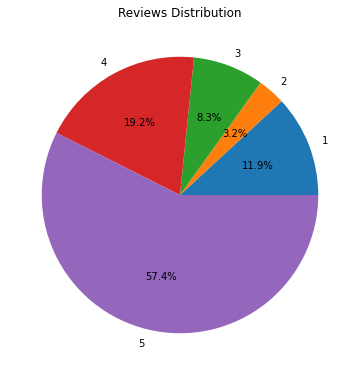

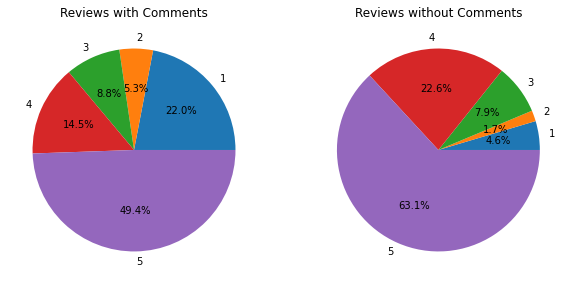

In [91]:
fig1 = plt.figure(figsize=(6,6))
ax = fig1.add_axes([0.1, 0.1, 0.8, 0.8])
lab = [1,2,3,4,5]
review_count = data['review_score'].value_counts(sort=False)
ax.pie(review_count, labels=lab, autopct='%1.1f%%')
ax.set_title('Reviews Distribution')
fig2, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.pie(reviews_with_comments['review_score'].value_counts(sort=False), labels=lab, autopct='%1.1f%%')
ax1.set_title('Reviews with Comments')
ax2.pie(reviews_without_comments['review_score'].value_counts(sort=False), labels=lab, autopct='%1.1f%%')
ax2.set_title('Reviews without Comments')

Here the graph shows that the customers who post reviews along with comments are less happier than the customers who do not prefer posting the comment. We could say this as the percent of review scores less than 4 is just 14% among the customers who have not posted the reviews, where as it is more than 36% among those who have posted the review comments.

#### Review Distribution and Average Delivery Time

Text(0, 0.5, 'Average Delivery Time')

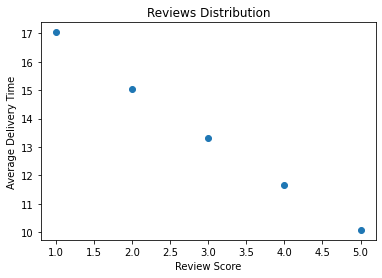

In [92]:
average_delivery_time = []
for l in lab:
  mean = data[data['review_score']==l].mean()
  average_delivery_time.append(mean['delivery_time'])
plt.scatter(lab, average_delivery_time)
plt.title('Reviews Distribution')
plt.xlabel('Review Score')
plt.ylabel('Average Delivery Time')

Thus, more the time taken for the delivery of a particular order, worse will be the reviews for it.

### Building the Machine Learning model



#### Data preprocessing

In [93]:
review_data = reviews_with_comments.drop(['order_id'], axis=1)
display(review_data)

,review_score,review_comment_message
3,5,Recebi bem antes do prazo estipulado.
4,5,Parabéns lojas lannister adorei comprar pela I...
9,4,aparelho eficiente. no site a marca do aparelh...
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,5,"Vendedor confiável, produto ok e entrega antes..."
...,...,...
99983,5,Entregou dentro do prazo. O produto chegou em ...
99990,3,"O produto não foi enviado com NF, não existe v..."
99996,5,"Excelente mochila, entrega super rápida. Super..."
99998,1,Solicitei a compra de uma capa de retrovisor c...


In [94]:
processed_comment = []
for sentence in review_data['review_comment_message'].values:
  sentence = sentence.replace('\r', ' ')
  sentence = sentence.replace('\\"', ' ')
  sentence = sentence.replace('\n', ' ')
  sentence = re.sub(r"http\S+", '', sentence)
  sentence = re.sub(r'[^\w]', ' ', sentence)
  sentence = re.sub(r'\s+', ' ', sentence)
  sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)
  processed_comment.append(sentence.lower().strip())
review_data['processed_comment'] = processed_comment
review_data = review_data.drop(['review_comment_message'], axis =1)
display(review_data)

,review_score,processed_comment
3,5,recebi bem antes do prazo estipulado
4,5,parab ns lojas lannister adorei comprar pela i...
9,4,aparelho eficiente no site a marca do aparelho...
12,4,mas um pouco travando pelo valor ta boa
15,5,vendedor confi vel produto ok e entrega antes ...
...,...,...
99983,5,entregou dentro do prazo o produto chegou em c...
99990,3,o produto n o foi enviado com nf n o existe ve...
99996,5,excelente mochila entrega super r pida super r...
99998,1,solicitei a compra de uma capa de retrovisor c...


In [95]:
X_train, X_val, y_train, y_val = train_test_split(review_data['processed_comment'], review_data['review_score'], test_size=0.5, random_state=43)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.4, random_state=67)

In [96]:
display(X_train)
print('--------------------------------------------------------------------')
display(X_val)
print('--------------------------------------------------------------------')
display(X_test)

26719               enviou pelos correios e ate agora nada
21667                     esperando o produto para avaliar
50334                                        chegou r pido
57699    solicitei o cancelamento da compra dentro do p...
99643    comprei 2 leo de menaleuca mas recebi apenas u...
                               ...                        
60374    a b blia linda muito satisfeita o produto cheg...
44134    entregaram o produto conforme combinado no pra...
97582    a maquina linda f cil de usar forte silenciosa...
47343                                               adorei
33689                 excelente compra e excelente produto
Name: processed_comment, Length: 20876, dtype: object

--------------------------------------------------------------------


36627                 gostei bastante do produto recomendo
18002    chegou antes do prazo e ainda n o pude utiliza...
20890    compra realizada de forma f cil r pida e entre...
39489            n o o mesmo produto da foto mais n o ruim
89231                      tapete muito fino e pelos finos
                               ...                        
10871                    macio regul vel muito confortavel
72750    ainda n o recebi o produto e o status diz que ...
52316    so recebi uma unidade comprei dois aparelhos p...
5943                   produto bom foi enviado rapidamente
72663                                   agilidade no envio
Name: processed_comment, Length: 12526, dtype: object

--------------------------------------------------------------------


35824    o produto n o foi entregue e n o obtive nenhum...
39885    nao recebi o produto certo me senti enganada e...
26182                     muito bom chegou dentro do prazo
82717    veio antes do prazo produto original e lacrado...
87596    quadro muito bonito pra quarto eu super recomendo
                               ...                        
98067    amei muito linda e bem feita atendeu minhas ex...
31186                 produto de excelente qualidade lindo
86556    produto dentro do discriminado entregue antes ...
82822              tecido um pouco inferior mas pelo pre o
39130    pedido j tinha um longo prazo para entrega e a...
Name: processed_comment, Length: 8351, dtype: object

#### Testing a model over CountVectorizer for text extraction

In [97]:
# Vectorizing the text
vectorizer = CountVectorizer(min_df=10, max_features=900, ngram_range=(1,2))
vectorizer.fit(X_train.values)
X_train_1 = pd.DataFrame.sparse.from_spmatrix(vectorizer.transform(X_train.values))
X_val_1 = pd.DataFrame.sparse.from_spmatrix(vectorizer.transform(X_val.values))
X_test_1 = pd.DataFrame.sparse.from_spmatrix(vectorizer.transform(X_test.values))

In [98]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=10.0)
lr.fit(X_train_1, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Here, we can see that the linear model does not converge to the optimum fit i.e. the loss function keeps increasing with each iteration. Thus, we need to look up for different models

In [99]:
print("Training score of LogisticRegression: ", accuracy_score(y_val, lr.predict(X_val_1)))

Training score of LogisticRegression:  0.6586300494970462


In [100]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=100)
rf.fit(X_train_1, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [101]:
print("Training score of Random Forest Classifier: ", accuracy_score(y_val, rf.predict(X_val_1)))

Training score of Random Forest Classifier:  0.6529618393741019


#### Testing a model over TdidfVectorizer for text extraction

In [102]:
# Vectorizing the text
vectorizer = TdidfVectorizer(min_df=10, ngram_range=(1,2))
vectorizer.fit(X_train.values)
X_train_2 = pd.DataFrame.sparse.from_spmatrix(vectorizer.transform(X_train.values))
X_val_2 = pd.DataFrame.sparse.from_spmatrix(vectorizer.transform(X_val.values))
X_test_2 = pd.DataFrame.sparse.from_spmatrix(vectorizer.transform(X_test.values))

In [103]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=10.0)
lr.fit(X_train_2, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [104]:
print("Training score of LogisticRegression: ", accuracy_score(y_val, lr.predict(X_val_2)))

Training score of LogisticRegression:  0.6586300494970462


In [105]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=100)
rf.fit(X_train_2, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [106]:
print("Training score of Random Forest Classifier: ", accuracy_score(y_val, rf.predict(X_val_2)))

Training score of Random Forest Classifier:  0.653121507264889


Here both the classifiers show similar sort of behaviur on the data, and both perform equally poor. Thus, we need to look for more advanced techniques for Machine Learning of the data for more accurate prediction.

### Scope for Improvements


1.   We could try out differenc techniques like Word2Vec, etc. for text vectorisation. Deep Learning Models like CNNs can be trained over the data. We have seen BERT Classifier working well for text recognition and thus can be used for the purpose as well.
2.   The poor accuracy is due to the larger number of classes for the multiclass classification in this problem, this can be dealt with by clustering the reviews as positive reviews for review_score of 4 and 5, and negative otherwise.
3.   For the purpose of this task, we have considered training the model over just the review_comment_message text. Other variables can be considered as well along with these to improve upon the accuracy for review_score prediction.
